Workflow:
--

1. Create subsequences from time series data
2. Cluster subsequences using clustering to find behaviours in one model
3. Cluster on different models to compare the behaviours of different models
4. Plot results

Imports
--

In [3]:
from IPython.display import clear_output
!git clone https://github.com/philippwulff/behaviour_mining.git
!pip install kneed # for finding the knee of the eps optimization in DBSCAN
!pip3 install tslearn # time series analysis
!pip install dtaidistance # fast dtw distance computation
clear_output()

In [4]:
import os
import time

import numpy as np
import pandas as pd

from scipy.signal import find_peaks
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

from sklearn.cluster import DBSCAN, KMeans, OPTICS, cluster_optics_dbscan, cluster_optics_xi, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from nltk.cluster.kmeans import KMeansClusterer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

#### Custom DTW metric.

In [5]:
#custom dtw metric
from scipy.spatial import distance
import numpy as np
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]


# faster implementation (is linearization)
from fastdtw import fastdtw
def mydtw(x, y):
    distance, path = fastdtw(x, y)
    return distance


# even faster (C implementation)
from dtaidistance.dtw import distance_fast

## Prepare documentation style 

In [6]:
# I could not use the Arial font with the default version of matplotlib
!pip install matplotlib==3.1.1

import matplotlib.pyplot as plt
import matplotlib
matplotlib.__version__

     |████████████████████████████████| 13.1MB 239kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


'3.2.2'

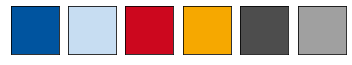

In [7]:
# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      # [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255

ax = plt.figure().subplots(nrows=1, ncols=color_map.shape[0])
for num, c in enumerate(color_map):
    ax[num].imshow([[c]])
    ax[num].get_xaxis().set_ticks([])
    ax[num].get_yaxis().set_ticks([])
plt.show()

In [8]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [9]:
# define text style and size

# size for the text
params = {'font.size' : 16,
          'axes.titlesize': 'medium',   # these are relative to font.size
          'axes.labelsize': 'medium',
          'font.weight': 500,
          # 'axes.titleweight': 'bold',     # these are relative too
          'axes.labelweight': 'normal',
          'font.family' : 'sans-serif',
          'font.sans-serif': 'Arial',
          'legend.fontsize': 12
          }
plt.rcParams.update(params)
fig = plt.figure()

# select the correct size of the plot in advance
a4_breite_cm = 21
seitenraender = 2.5 + 2.5
grafik_scale = 1
width = 11.69 #(a4_breite_cm-seitenraender) * 0.393701
height = 7.5 * 0.393701

fig.set_size_inches(width, height)

# How to save a vector graphics plot

#plt.savefig("../myplot.eps",   # alternatively use .svg
#            format="eps",
#            dpi=1000, # recommendation for publication plots
#            bbox_inches='tight', # Plot will be occupy a maximum of available space
#            )

<Figure size 1169x295.276 with 0 Axes>

# Get data

In [10]:
def read_all(folder, nrows=None):
    """
    Read all .csv files from a directory and return the pandas Dataframes.
    """
    dfs = {}

    for root,dirs,files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, str(file))
                print('Creating DataFrame from {}'.format(path))
                df = pd.read_csv(path, nrows=nrows)
                dfs[path] = df

    return dfs

In [11]:
# Reduce datacount so to not exceed RAM
nrows = None
path = 'behaviour_mining/data/BipedalWalker-v3/'
dfs = read_all(path, nrows)

Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv


In [12]:
dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].head()

,done,rewards,cumulative_reward,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,obs_11,obs_12,obs_13,obs_14,obs_15,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,action_0,action_1,action_2,action_3
0,0.0,-0.152152,0.000000,-1.553152,0.058755,-2.111050,-0.150687,2.715659,0.936015,0.653329,-1.196846,1.073211,-3.279606,1.274947,-0.284248,-1.137195,1.535426,3.946275,3.969125,3.979726,3.973202,3.942354,3.876772,3.759370,3.565766,1.510411,0.112139,-0.473087,-1.000000,0.267759,-1.000000
1,0.0,-0.116266,-0.152152,-1.476143,0.548042,-2.000170,-0.556585,2.694441,-0.067539,0.361258,-1.196319,-0.931783,-3.029333,1.087949,-0.521497,-1.137885,-0.651285,3.890856,3.913426,3.923912,3.917504,3.887100,3.822428,3.706634,3.515666,1.510411,0.112139,-1.000000,-1.000000,0.271426,-0.428934
2,0.0,-0.155962,-0.268418,-1.393407,0.584033,-1.963198,-0.578523,2.501582,-0.995438,0.164044,-0.819076,-0.931783,-2.879289,0.738007,-0.285848,0.999536,-0.651285,3.832627,3.854902,3.865268,3.858983,3.829043,3.765327,3.651223,3.463026,1.510411,0.112139,-1.000000,-0.224652,1.000000,0.632351
3,0.0,-0.173834,-0.424380,-1.288625,0.738060,-1.942015,-1.047063,2.249776,-1.258509,-0.106864,-1.196320,-0.931783,-2.497924,1.714268,-0.415467,-0.698416,-0.651285,3.730530,3.752289,3.762444,3.756373,3.727250,3.665209,3.554070,3.370729,1.510411,0.112139,-0.879462,-1.000000,0.655143,-0.277381
4,0.0,-0.156413,-0.598214,-1.163460,0.881893,-1.908166,-1.135971,1.999996,-1.258509,-0.379750,-1.186960,-0.931783,-2.496081,0.046901,-0.158971,1.127991,-0.651285,3.621193,3.642399,3.652328,3.646487,3.618237,3.557990,3.450026,3.271887,1.510411,0.112139,-0.330683,-0.005658,-0.428750,0.846328


# Prepare Subsequence Time Series (STS)

Obs 13 was most helpful for the RF

In [13]:
time_series = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv']['obs_4'][:10000]

Create a nice plot for the text.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


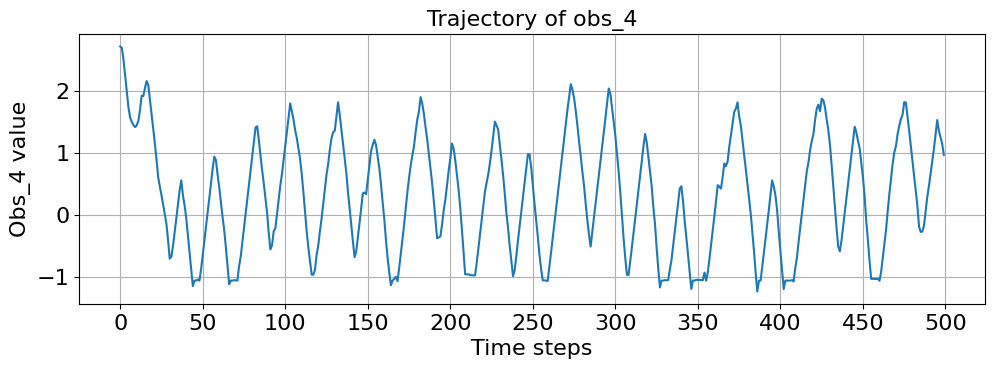

In [14]:
# plot exerpt.
plt.figure().set_size_inches(width, 3.5)
plt.plot(time_series[:500])
plt.grid()
plt.xlabel('Time steps')
plt.ylabel('Obs_4 value')
plt.title('Trajectory of obs_4')
plt.xticks([i*50 for i in range(500//50 + 1)])

plt.savefig("times_series_plot_obs_4.eps",
            format="eps",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

In [15]:
def get_sts(x, w):
    """Returns subsequence time series."""
    n = len(x)
    sts = []
    for i in range(n-w+1):
        _ = x[i:i+w]
        sts.append(_)
        
    return np.array(sts)

In [16]:
%%time
window = 15

sts = get_sts(time_series, window)
sts_df = pd.DataFrame(sts)

print(time_series.shape, sts_df.shape)

(10000,) (9986, 15)
CPU times: user 742 ms, sys: 19.1 ms, total: 761 ms
Wall time: 766 ms


In [17]:
# drop all subsequences with all zero values.
sts_df = sts_df[(sts_df != 0).all(axis=1)]
sts_df.shape

(9986, 15)

In [18]:
X = sts_df.values

#### Pairplot for the text

In [19]:
# sns.set_style("darkgrid", {"axes.facecolor": "0"})
# 
# sns.set(font_scale=1.5)
# g = sns.pairplot(data=sts_df.iloc[::100, :], plot_kws={"s":4, "color":color_map[0], "edgecolor":None}, diag_kws= {'color': color_map[0]}, corner=True)#plot_kws={"s": 4})
# g.fig.set_size_inches(width, 12)
# g.set(yticks=[])
# g.set(xticks=[])
# g.fig.suptitle("Pairplot across 15 dimensions of SWS data", y=1.03, fontsize=19)
# #g.fig.set_edgecolor(color_map[-3])
# plt.show()
# 
# # g.fig.text(-0.02, 0.45, "Subtrajectory values at each time step", ha="center", va="top", fontsize = 22, rotation=90)
# g.fig.text(-0.02, 0.5, "Subtrajectory values at each time step", ha="center", va="center", fontsize = 19, rotation=90)
# g.fig.text(0.5, -0.02, "Subtrajectory values at each time step", ha='center', va="center", fontsize = 19)
# 
# g.savefig("pairplot_obs_4.svg", format="svg", dpi=500);

# STS Clustering on 1 model

## With DBSCAN

### Determining the optimal parameters for the DBSCAN

Find optimal parameters for DBSCAN ([link](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc))

#### Plotting the k-dist graph using the STS-data. with Euclidean distance

Best eps for 4-dist, k=4: 0.7116382818298673; Time: 0.17 sec
Best eps for 10-dist, k=10: 0.8538321022583785; Time: 0.21 sec
Best eps for 15-dist, k=15: 0.9892521192650022; Time: 0.25 sec
Best eps for 50-dist, k=50: 1.5072516118604102; Time: 0.37 sec


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Best eps for 100-dist, k=100: 1.512846632076199; Time: 0.55 sec


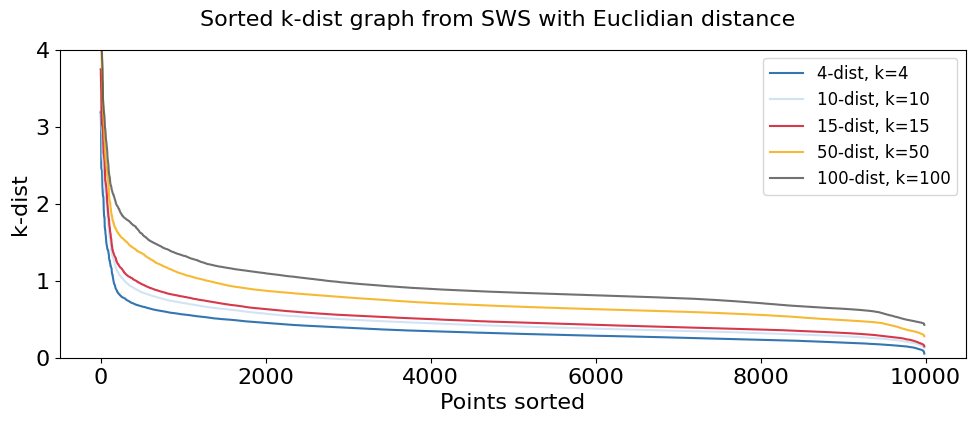

In [18]:
n_neighbors_perc = [0.0001, 0.001, 0.005, 0.01]
n_vals = [int(perc*len(time_series)) for perc in n_neighbors_perc if not int(perc*len(time_series)) in [0, 1]]
n_neighbors = {'4-dist, k=4': 4,
               '10-dist, k=10': 10,
               }
# insert window size a k
n_neighbors['{}-dist, k={}'.format(X.shape[1], X.shape[1])] = X.shape[1]
# insert other ks
for n in n_vals:
    n_neighbors['{}-dist, k={}'.format(n, n)] = n

# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      # [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255

fig = plt.figure(figsize=(width, 4))
ax = fig.subplots(nrows=1, ncols=1)

iter = 0
for label, k in zip(n_neighbors.keys(), n_neighbors.values()):
    start_time = time.time()

    # using the sklearn NN algorithms to compute the euclidean distances to all
    # other points and find the nearest ones as well as their distances
    neigh = NearestNeighbors(n_neighbors=k, metric='minkowski')
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)

    distances = distances[:,k-1]
    distances = np.sort(distances, axis=0)[::-1] # sort in descending order
    y = distances

    #x = range(1, len(y)+1)
    x = range(len(y))
    
    from kneed import KneeLocator
    kn = KneeLocator(x, y, S=3, curve='convex', direction='decreasing')

    time_iv = time.time()-start_time
    print('Best eps for {}: {}; Time: {:.2f} sec'.format(label, kn.knee_y, time_iv))

    ax.plot(y, alpha=0.8, label=label, c=color_map[iter])
    #plt.scatter(kn.knee, kn.knee_y, marker='x', c='r');

    ax.set_xlabel('Points sorted')
    ax.set_ylabel('k-dist')

    iter += 1

ax.set_ylim(0, 4)
ax.legend()

fig.suptitle('Sorted k-dist graph from SWS with Euclidian distance', size=16)
fig.savefig("k dist graph SWS euclidean.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )


#### Using the DTW metric on STS data. TAKES VERY LONG TO RUN!

Best eps for 4-dist, k=4: 0.37740605238653907; Time: 104.87 sec
Best eps for 10-dist, k=10: 0.5191039403290112; Time: 112.67 sec
Best eps for 15-dist, k=15: 0.524857593402716; Time: 117.22 sec
Best eps for 50-dist, k=50: 0.7298879794825177; Time: 130.08 sec
Best eps for 100-dist, k=100: 0.9081878478170207; Time: 145.33 sec


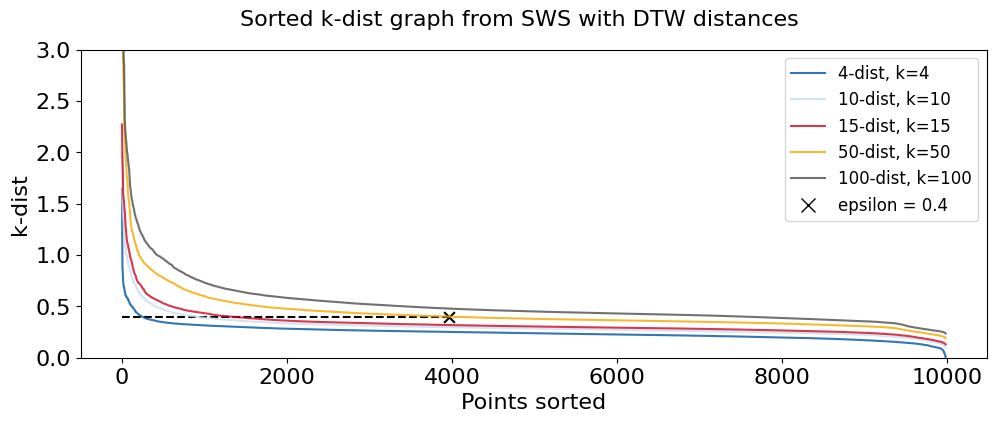

In [19]:
# USING distance_fast from dtaidistance.dtw

n_neighbors_perc = [0.001, 0.005, 0.01]
n_vals = [int(perc*len(time_series)) for perc in n_neighbors_perc if not int(perc*len(time_series)) in [0, 1]]
n_neighbors = {'4-dist, k=4': 4,
               '10-dist, k=10': 10,
               }
# insert window size a k
n_neighbors['{}-dist, k={}'.format(X.shape[1], X.shape[1])] = X.shape[1]
# insert other ks
for n in n_vals:
    n_neighbors['{}-dist, k={}'.format(n, n)] = n

# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      # [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255

fig = plt.figure(figsize=(width, 4))
ax = fig.subplots(nrows=1, ncols=1)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

iter = 0
for label, k in zip(n_neighbors.keys(), n_neighbors.values()):
    start_time = time.time()

    # using the sklearn NN algorithms to compute the euclidean distances to all
    # other points and find the nearest ones as well as their distances
    neigh = NearestNeighbors(n_neighbors=k, metric=distance_fast)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)

    distances = distances[:,k-1]
    distances = np.sort(distances, axis=0)[::-1] # sort in descending order
    y = distances

    #x = range(1, len(y)+1)
    x = range(len(y))
    
    from kneed import KneeLocator
    kn = KneeLocator(x, y, S=3, curve='convex', direction='decreasing')

    time_iv = time.time()-start_time
    print('Best eps for {}: {}; Time: {:.2f} sec'.format(label, kn.knee_y, time_iv))

    ax.plot(y, alpha=0.8, label=label, c=color_map[iter])
    #plt.scatter(kn.knee, kn.knee_y, marker='x', c='r');

    if k==50:
        point_x = find_nearest(distances, 0.4)[0]
        ax.scatter(point_x, 0.4, c="black", marker="x", s=60)
        ax.hlines(y=0.4, xmin=0, xmax=point_x, colors=["black"], linestyles="--")
        marker_legend = mlines.Line2D([], [], color='black', marker='x', 
                                      linestyle='None', markersize=10, 
                                      label='epsilon = 0.4')

    iter += 1

ax.set_xlabel('Points sorted')
ax.set_ylabel('k-dist')
ax.set_ylim(0, 3)

handles, labels = ax.get_legend_handles_labels()
if marker_legend:
    handles.append(marker_legend)
plt.legend(handles=handles)

fig.suptitle("Sorted k-dist graph from SWS with DTW distances", size=16)

fig.savefig("k dist graph SWS DTW.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

### DBSCAN with the optimized parameters and visualisations of the clusters

In [20]:
%%time

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=50, metric=distance_fast).fit(X) # 0.4
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 748
CPU times: user 1min 38s, sys: 7.41 s, total: 1min 46s
Wall time: 1min 45s


Visualising the found clusters.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


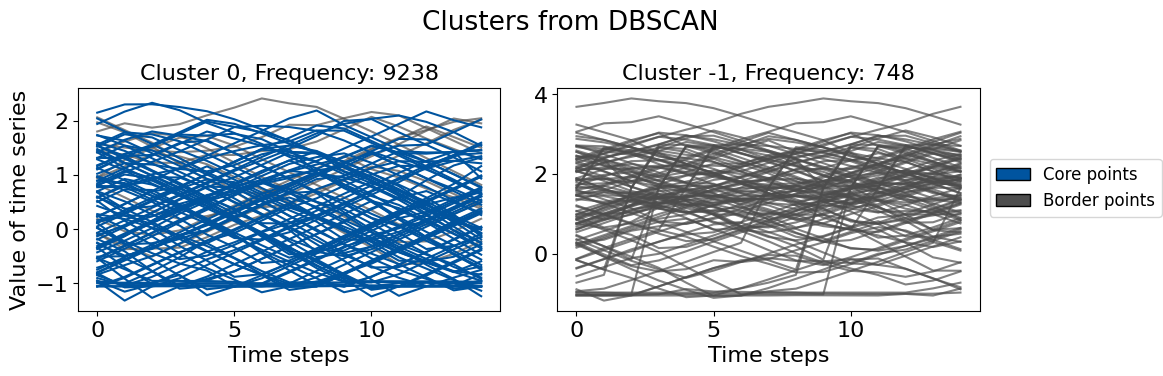

In [21]:
nrows = int(np.sqrt(len(set(db.labels_))))
ncols = nrows + 1 if nrows**2+1==len(set(db.labels_)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 3.5))# figsize=(ncols*6, nrows*4))

for i, label in enumerate(set(labels)): 

    cluster_ind = np.where([db.labels_ == label])[1]
    # plot only every 100th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 100: 
        cluster_ind = cluster_ind[::len(cluster_ind)//100]
        is_selection = True

    # determine core and border points of the cluster
    core_sample_ind = [i for i in cluster_ind if i in db.core_sample_indices_]
    border_sample_ind = [i for i in cluster_ind if i not in db.core_sample_indices_]
    core_points = sts_df.values[core_sample_ind, :]
    border_points = sts_df.values[border_sample_ind, :]

    # plot border points
    for yy in border_points:
        ax.ravel()[i].plot(yy, c=color_map[-2], alpha=0.7)
    # plot core points
    for yy in core_points:
        ax.ravel()[i].plot(yy, c=color_map[0])
    
    label_freq = np.where([db.labels_==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))

    ax.ravel()[i].set_xlabel("Time steps")

ax.ravel()[0].set_ylabel("Value of time series")

blue_patch = mpatches.Patch(facecolor=color_map[0], edgecolor='#000000')
grey_patch = mpatches.Patch(facecolor=color_map[-2], edgecolor='#000000')
fig.legend(handles=[blue_patch, grey_patch],labels=["Core points", "Border points"], loc="center right", borderaxespad=0.1)
# fig.suptitle("Clusters from DBSCAN")
fig.text(0.5, 1.05, "Clusters from DBSCAN", ha="center", va="center", fontsize=19)#matplotlib.rcParams["figure.titlesize"])
fig.tight_layout()
plt.subplots_adjust(right=0.85)
fig.savefig("clusters from DBSCAN.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

Apparantly the DBSCAN discovered one major cluster which includes most of the samples.

Visualising where certain clusters where found in the original time series.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


CPU times: user 2.02 s, sys: 12.5 ms, total: 2.04 s
Wall time: 2.05 s


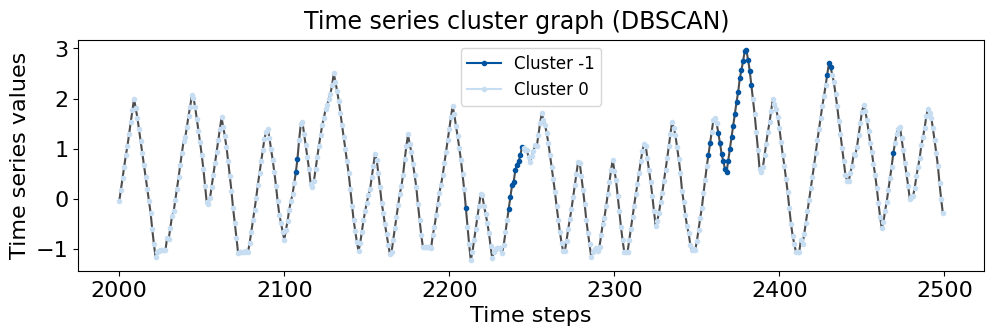

In [22]:
%%time

plot_slice = slice(2000, 2500) # 0, 500

sts_X = sts_df.values[:, :]

colors = cm.rainbow(np.linspace(0, 1, len(set(db.labels_))))
fig = plt.figure(figsize=(width, 3))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(time_series[plot_slice], c=color_map[-2])

for x in range(plot_slice.start, plot_slice.stop):
    y = sts_X[x, 0]
    label = db.labels_[x]

    ax.plot(x, y, marker='o', markersize=3, color=color_map[label+1], 
             label='Cluster {}'.format(label))
    # remove redundant labels in the plot
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels, loc='best')
    # visualize window size int the plot
    #plt.plot(range(x, x+15), [y for i in range(15)], color=colors[label+1])

fig.suptitle('Time series cluster graph (DBSCAN)', size=17)
ax.set_xlabel('Time steps')
ax.set_ylabel('Time series values')

fig.savefig("clusters from DBSCAN in time.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

## With OPTICS

In [23]:
%%time

optics = OPTICS(min_samples=0.1, metric=distance_fast, max_eps=2)
optics.fit(X[:, :])

reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]
space = np.arange(len(X[:, :]))

CPU times: user 8min 52s, sys: 38.6 s, total: 9min 31s
Wall time: 9min 29s


In [24]:
labels_xi, clusters_xi = cluster_optics_xi(reachability=optics.reachability_,
                                           predecessor=optics.predecessor_,
                                           ordering=optics.ordering_,
                                           min_samples=optics.min_samples, xi=0.001)

labels_xi_ord = labels_xi[optics.ordering_]

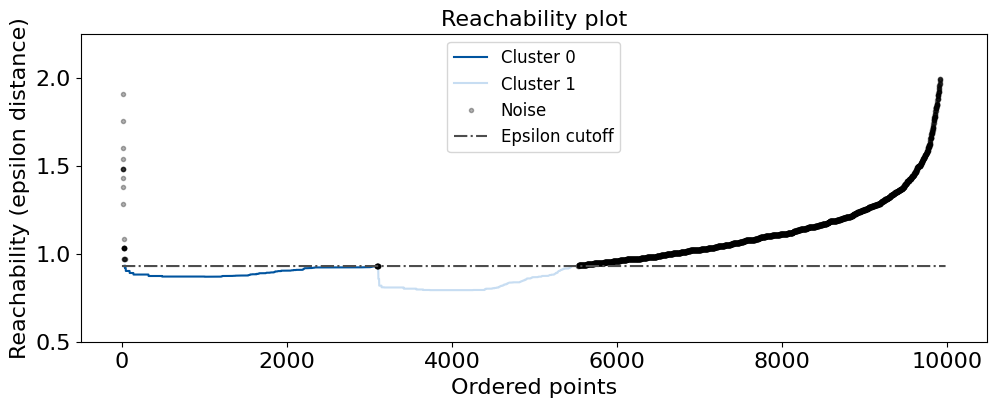

In [25]:
eps_value = 0.93 # this value represents a cutoff for a dbscan to perforem clustering
# dbscan clustering would be an alternative to the Xi clustering

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, 4))
#fig, ax2 = plt.subplots(nrows=3, ncols=1, figsize=(15, 7))

# Reachability plot
num_labels = len(set(labels_xi_ord))-1 if -1 in labels_xi_ord else len(set(labels_xi_ord))
for klass in range(num_labels):
    Xk = space[labels_xi_ord == klass]
    Rk = reachability[labels_xi_ord == klass]
    ax.plot(Xk, Rk, c=color_map[klass], alpha=1, label='Cluster {}'.format(klass))
ax.plot(space[labels_xi_ord == -1], reachability[labels_xi_ord == -1], 'k.', alpha=0.3, label='Noise')
# plot eps_value for dbscan
ax.plot(space, np.full_like(space, eps_value, dtype=float), 'k-.', alpha=1, label='Epsilon cutoff', c=color_map[-2])
ax.set_ylabel('Reachability (epsilon distance)')
ax.set_xlabel('Ordered points')
ax.set_title('Reachability plot')
ax.set_ylim(0.5, 2.25)

ax.legend(loc="upper center")

fig.savefig("reachability plot.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

### Predict clusters fom OPTICS reachability calculation with Xi method

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


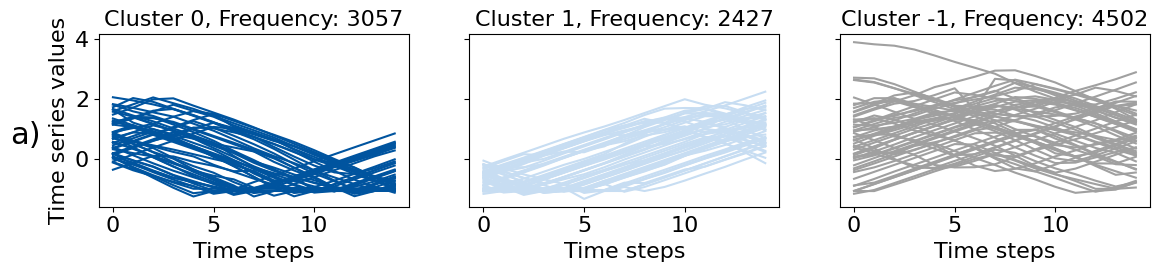

In [26]:
nrows = int(np.sqrt(len(set(labels_xi))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_xi)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 3), sharey=True)# ncols*6, nrows*4))

for i, label in enumerate(set(labels_xi)): 

    cluster_ind = np.where([labels_xi == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    points = X[cluster_ind, :]

    # plot cluster
    for ii, yy in enumerate(points):
        ax.ravel()[i].plot(yy, c=color_map[label])
    
    label_freq = np.where([labels_xi==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
    ax.ravel()[i].set_xlabel("Time steps")

ax.ravel()[0].set_ylabel("Time series values")

fig.text(0.00, 0.5, "a)", ha="center", va="center", fontsize=22)
fig.tight_layout()
        
fig.savefig("OPTICS xi extraction clusters.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

### Predict clusters fom OPTICS reachability calculation with DBSCAN

CPU times: user 493 ms, sys: 118 ms, total: 611 ms
Wall time: 490 ms


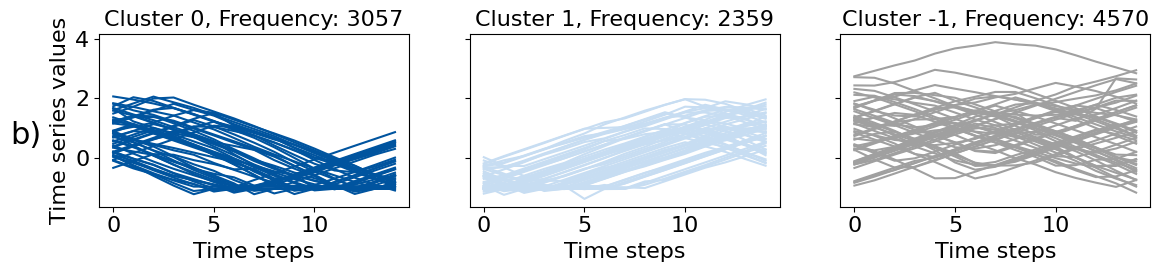

In [27]:
%%time

labels_dbscan = cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=eps_value)


nrows = int(np.sqrt(len(set(labels_dbscan))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_dbscan)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 3), sharey=True)# ncols*6, nrows*4))

for i, label in enumerate(set(labels_dbscan)): 

    cluster_ind = np.where([labels_dbscan == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    points = X[cluster_ind, :]

    # plot cluster
    for ii, yy in enumerate(points):
        ax.ravel()[i].plot(yy, c=color_map[label])
    
    label_freq = np.where([labels_dbscan==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
    ax.ravel()[i].set_xlabel("Time steps")

ax.ravel()[0].set_ylabel("Time series values")

fig.text(0, 0.5, "b)", ha="center", va="center", fontsize=22)
fig.tight_layout()
        
fig.savefig("OPTICS DBSCAN extraction clusters.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

### Visualize where clusters where found in the time series.

CPU times: user 2.32 s, sys: 121 ms, total: 2.44 s
Wall time: 2.32 s


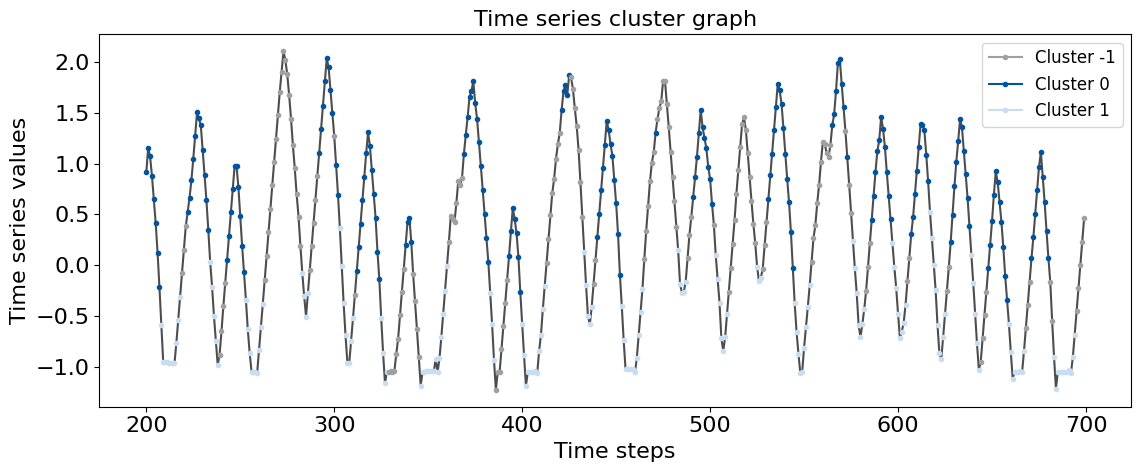

In [28]:
%%time
__ = labels_xi
plot_slice = slice(200, 700)

sts_X = sts_df.values[:, :]

fig = plt.figure(figsize=(width, 5))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(time_series[plot_slice], c=color_map[-2])

for x in range(plot_slice.start, plot_slice.stop):
    y = sts_X[x, 0]
    label = __[x]

    plt.plot(x, y, marker='o', markersize=3, color=color_map[label], 
             label='Cluster {}'.format(label))
    # remove redundant labels in the plot
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    plt.legend(handles, labels, loc='best')
    # visualize window size int the plot
    #plt.plot(range(x, x+15), [y for i in range(15)], color=colors[label+1])

ax.set_title('Time series cluster graph')
ax.set_xlabel('Time steps')
ax.set_ylabel('Time series values')

fig.tight_layout()
        
fig.savefig("OPTICS time series cluster graph.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

## With KMeans

In [29]:
%%time

kmeans = KMeansClusterer(num_means=3, distance=distance_fast)
assigned_clusters = kmeans.cluster(X, assign_clusters=True)
labels_kmeans = np.array(assigned_clusters)
means_kmeans = kmeans.means()

CPU times: user 5.1 s, sys: 328 ms, total: 5.43 s
Wall time: 5.43 s


In [30]:
def get_medoids(means, points, labels, metric):
    medoids = []
    medoid_labels = []
    for l in set(labels):
        m = means[l]
        d = np.inf
        medoid = None
        for i in np.where([labels==l])[1]:
            d_ = metric(points[i], m)
            if d_ < d:
                d = d_
                medoid = points[i]
        medoids.append(medoid)
        medoid_labels.append(l)
    return medoids, medoid_labels

In [31]:
medoids, medoid_labels = get_medoids(means_kmeans, X, labels_kmeans, distance_fast)

KMeans from sklearn only allows the use of euclidean distance.

In [ ]:
#kmeans = KMeans(n_clusters=3)
#kmeans.fit(X)
#
#labels_kmeans = kmeans.labels_

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


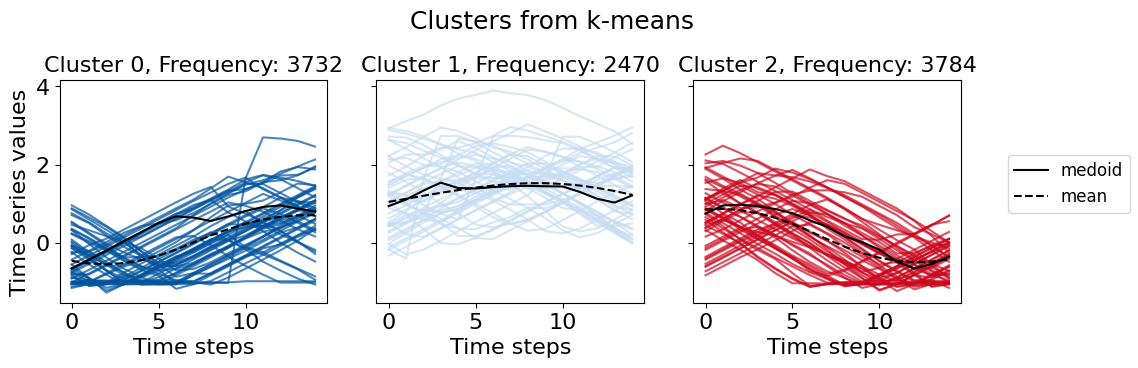

In [32]:
nrows = int(np.sqrt(len(set(labels_kmeans))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_kmeans)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 3.5), sharey=True)# ncols*6, nrows*4))

for i, label in enumerate(set(labels_kmeans)): 

    cluster_ind = np.where([labels_kmeans == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # get points
    points = X[cluster_ind, :]

    # plot cluster
    for ii, yy in enumerate(points):
        ax.ravel()[i].plot(yy, c=color_map[label], alpha=0.7)
    
    #plot medioid
    ax.ravel()[i].plot(medoids[i], c='black', label='medoid')
    # plot mean
    ax.ravel()[i].plot(means_kmeans[i], c='black', linestyle='--', label='mean')

    label_freq = np.where([labels_kmeans==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
    
    # ax.ravel()[i].legend()  
    handles, labels = ax.ravel()[i].get_legend_handles_labels()
    ax.ravel()[i].set_xlabel("Time steps")

fig.legend(handles, labels, loc='right')

ax.ravel()[0].set_ylabel("Time series values")
fig.text(0.5, 1.03, "Clusters from k-means", ha="center", va="center", fontsize=18)
fig.tight_layout()     

plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend

        
fig.savefig("Kmeans clusters.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

CPU times: user 3.2 s, sys: 115 ms, total: 3.32 s
Wall time: 3.19 s


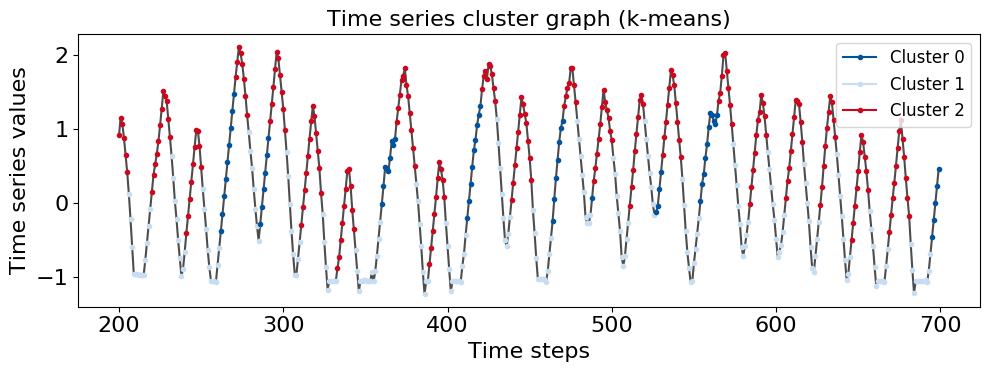

In [ ]:
%%time
__ = labels_kmeans
plot_slice = slice(200, 700)

sts_X = sts_df.values[:, :]

colors = cm.rainbow(np.linspace(0, 1, len(set(__))))
fig = plt.figure(figsize=(width, 4))
ax = fig.subplots(nrows=1, ncols=1)

ax.plot(time_series[plot_slice], c=color_map[-2])

for x in range(plot_slice.start, plot_slice.stop):
    y = sts_X[x, 0]
    label = __[x]

    ax.plot(x, y, marker='o', markersize=3, color=color_map[label], 
             label='Cluster {}'.format(label))
    # remove redundant labels in the plot
    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels, loc='best')
    # visualize window size int the plot
    #plt.plot(range(x, x+15), [y for i in range(15)], color=colors[label+1])

ax.set_title('Time series cluster graph (k-means)', size=16)
ax.set_xlabel('Time steps')
ax.set_ylabel('Time series values')
fig.tight_layout()     

plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend

        
fig.savefig("Kmeans time series cluster graph.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

## With Agglomerative clustering

Using sklearn.cluster.AgglomerativeClustering

and https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram

How to use a custom distance metric with agglomerative clustering: https://gist.github.com/codehacken/8b9316e025beeabb082dda4d0654a6fa

In [33]:
# Method to calculate distances between all sample pairs
#from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import pairwise_distances

def dtw_affinity(X):
    return pairwise_distances(X, metric=distance_fast)

In [34]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [35]:
%%time

# setting distance_threshold=0 ensures we compute the full tree.
# AC does not allow a custom distance metric with ward linkage
ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None) # use euclidean dist
#ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity=dtw_affinity, linkage='single') # complete
#ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed')
#m = pairwise_distances(X, X, metric=distance_fast)
#ward = ward.fit(m)

ward = ward.fit(X)

CPU times: user 3.13 s, sys: 180 ms, total: 3.31 s
Wall time: 3.32 s


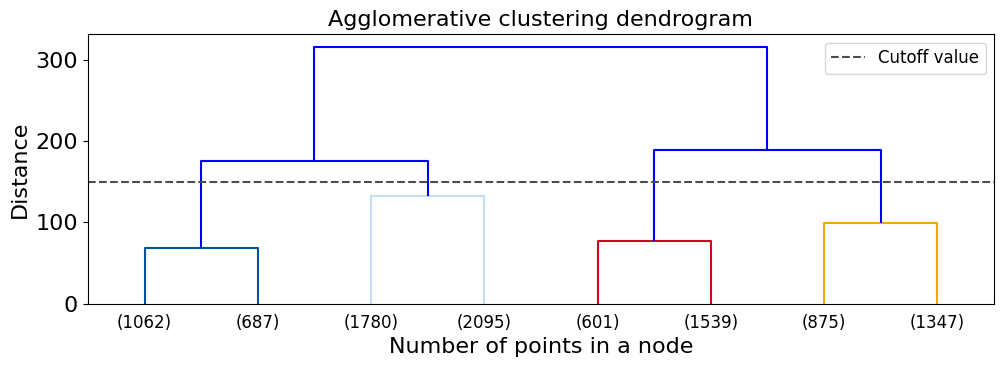

In [36]:
cmap = cm.rainbow(np.linspace(0, 1, 7))
# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      # [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255
# hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap])
hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in color_map])

plt.figure(figsize=(width, 3.5))

# plot the top three levels of the dendrogram
plot_dendrogram(ward, p=2, truncate_mode='level', color_threshold=150)
plt.axhline(y=150, color=color_map[-2], linestyle='--', label='Cutoff value')

plt.title('Agglomerative clustering dendrogram')
plt.xlabel("Number of points in a node")# (or index of point if no parenthesis).")
plt.ylabel("Distance")
plt.legend()
plt.savefig("agglomerative clustering dendrogram.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )
# fig.tight_layout()     
# plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend
   
# plt.show()

In [37]:
%%time

#ward1 = AgglomerativeClustering(n_clusters=3, affinity=dtw_affinity, linkage='average')
ward1 = AgglomerativeClustering(distance_threshold=150, n_clusters=None)

ward1.fit(X)

CPU times: user 3.1 s, sys: 6.44 ms, total: 3.11 s
Wall time: 3.11 s


In [38]:
labels_ward = ward1.labels_

means_ward = []
for label in range(len(set(labels_ward))):
    cluster_ind = np.where([labels_ward == label])[1]
    p = X[cluster_ind]
    means_ward.append(np.mean(p, axis=0))

medoids, medoid_labels = get_medoids(means_ward, X, labels_ward, distance_fast)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


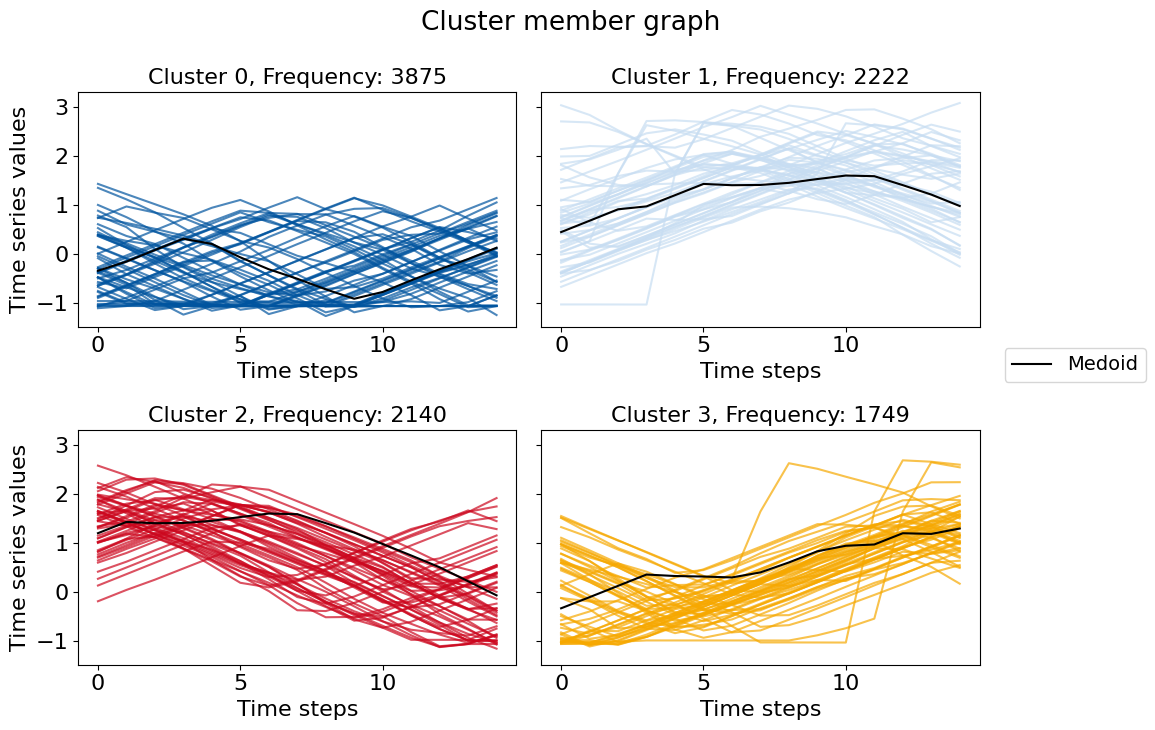

In [39]:
nrows = int(np.sqrt(len(set(labels_ward))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_ward)) else nrows + 2
nrows, ncols = 2, 2 # HARDCODE
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 7), sharey=True)# ncols*6, nrows*4))

for i, label in enumerate(set(labels_ward)): 

    cluster_ind = np.where([labels_ward == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # get points
    points = X[cluster_ind, :]

    # plot cluster
    for ii, yy in enumerate(points):
        ax.ravel()[i].plot(yy, alpha=0.7, c=color_map[label])
    
    #plot medioid
    ax.ravel()[i].plot(medoids[i], c='black', label='Medoid')
    # plot mean
    #ax.ravel()[i].plot(means_kmeans[i], c='black', linestyle='--', label='mean')

    label_freq = np.where([labels_ward==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))

    ax.ravel()[i].set_xlabel("Time steps")
    
    handles, labels = ax.ravel()[i].get_legend_handles_labels()    

fig.legend(handles, labels, loc="right", fontsize=14)    

ax.ravel()[0].set_ylabel("Time series values")
ax.ravel()[2].set_ylabel("Time series values")

fig.text(0.5, 1.03, 'Cluster member graph', va="center", ha="center", fontsize=19)

fig.tight_layout()
plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend

fig.savefig("agglomerative clustering clusters.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )
plt.show()

# STS Clustering on 7 models

Prepare the subsequence time series for a single feature/ observation for 7 models.

In [20]:
%%time

feature_name = 'obs_4'
time_series_len = 10000
window = 30

sts_df_all = pd.DataFrame()
for key, df in zip(dfs.keys(), dfs.values()):
    time_series = df[feature_name][:time_series_len]
    sts = get_sts(time_series, window)
    model_name = key.split('/')[-2]

    name_df = pd.DataFrame([model_name for i in range(len(sts))], columns=['model'])
    model_sts_df = pd.DataFrame(sts)
    model_df = pd.concat([name_df, model_sts_df], axis=1) # attach model name
    sts_df_all = pd.concat([sts_df_all, model_df], axis=0) # attach df for this model to df_all


# drop all subsequences with all zero values.
sts_df_all = sts_df_all[(sts_df_all != 0).all(axis=1)]
# shuffle df
sts_df_all = sts_df_all.sample(frac=1)

#X_all = StandardScaler().fit_transform(sts_df_all.iloc[:, 1:])
X_all = sts_df_all.iloc[:, 1:].values

print(sts_df_all.shape)

(69797, 31)
CPU times: user 5.17 s, sys: 75.6 ms, total: 5.25 s
Wall time: 5.25 s


## With DBSCAN

Evaluate good parameters for the DBSCAN

In [ ]:
# Plot k-dist plot to evaluate good parameters for the problem
# USING distance_fast from dtaidistance.dtw

n_neighbors = {#'2-dist, k=2': 2,
               #'3-dist, k=3': 3,
               #'4-dist, k=4': 4,
               #'10-dist, k=10': 10,
               #'35-dist, k=35': 35,
               '100-dist, k=100': 100
               }

plt.figure(figsize=(8, 5))
for label, k in zip(n_neighbors.keys(), n_neighbors.values()):
    start_time = time.time()

    # using the sklearn NN algorithms to compute the euclidean distances to all
    # other points and find the nearest ones as well as their distances
    neigh = NearestNeighbors(n_neighbors=k, metric=distance_fast)
    nbrs = neigh.fit(X_all)
    distances, indices = nbrs.kneighbors(X_all)

    distances = distances[:,k-1]
    distances = np.sort(distances, axis=0)[::-1] # sort in descending order
    y = distances

    x = range(len(y))
    
    from kneed import KneeLocator
    kn = KneeLocator(x, y, S=3, curve='convex', direction='decreasing')

    time_iv = time.time()-start_time
    print('Best eps for {}: {}; Time: {:.2f} sec'.format(label, kn.knee_y, time_iv))

    plt.plot(y, alpha=0.8, label=label)
    plt.scatter(kn.knee, kn.knee_y, marker='x', c='r');
    plt.title('sorted k-dist graph from sts')
    plt.xlabel('points sorted')
    plt.ylabel('k-dist')
    plt.legend()

plt.show()

Next cluster with the DBSCAN.

In [ ]:
%%time

# Compute DBSCAN
db = DBSCAN(eps=0.9, min_samples=35, metric=distance_fast).fit(X_all)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Visualise the discovered clusters.

In [ ]:
# map colors to different models
colors = cm.rainbow(np.linspace(0, 1, len(set(sts_df_all['model']))))
cmap = {}
for c, model_name in zip(colors, set(sts_df_all['model'])):
    cmap[model_name] = c


nrows = int(np.sqrt(len(set(db.labels_))))
ncols = nrows + 1 if nrows**2+1==len(set(db.labels_)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))

for i, label in enumerate(set(labels)): 

    cluster_ind = np.where([db.labels_ == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # determine core and border points of the cluster
    core_sample_ind = [i for i in cluster_ind if i in db.core_sample_indices_]
    border_sample_ind = [i for i in cluster_ind if i not in db.core_sample_indices_]
    # the first column is the model
    core_points = sts_df_all.values[core_sample_ind, 1:]
    border_points = sts_df_all.values[border_sample_ind, 1:]
    # get the models to the corresponding points
    core_point_models = sts_df_all.values[core_sample_ind, 0]
    border_point_models = sts_df_all.values[border_sample_ind, 0]

    # plot border points
    for ii, yy in enumerate(border_points):
        color = cmap[border_point_models[ii]]
        ax.ravel()[i].plot(yy, c=color, alpha=0.5)
    # plot core points
    for ii, yy in enumerate(core_points):
        color = cmap[core_point_models[ii]]
        ax.ravel()[i].plot(yy, c=color)
    
    label_freq = np.where([db.labels_==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
        
plt.show()

## With OPTICS

- Doc. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS
- Example from doc with reachability plot: https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
- Medium article on the algo: https://towardsdatascience.com/clustering-using-optics-cac1d10ed7a7


Here using DTW from fastdtw produces better results, but also is slower than distance_fast from dtainstance. 

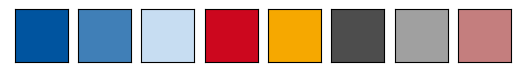

In [21]:
# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160],    # light medium grey
                      [196, 126, 126]
                      ])   
color_map = color_map / 255

ax = plt.figure().subplots(nrows=1, ncols=color_map.shape[0])
for num, c in enumerate(color_map):
    ax[num].imshow([[c]])
    ax[num].get_xaxis().set_ticks([])
    ax[num].get_yaxis().set_ticks([])
plt.show()

In [22]:
%%time

# Runs 2h 28min 31s

n = 10000

# reducing max_eps will result in shorter run times.
optics = OPTICS(min_samples=0.04, metric=mydtw)
optics.fit(X_all[:n, :])

reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]
space = np.arange(len(X_all[:n, :]))

# w=15, n=5000, ms=0.05, mydtw > 35min 7s > good
# w=30, n=5000, ms=0.05, mydtw > 57min 26s > very good

# w=30, n=10000, ms=0.05, mydtw > 2h 17min 20s > medium
# w=30, n=10000, ms=0.1, mydtw > 2h 20min 25s > worse
# w=30, n=10000, ms=0.03, mydtw > 2h 15min 24s > good1
# w=30, n=10000, ms=0.025, mydtw > 2h 10min 18s > good0
# w=30, n=10000, ms=0.04, mydtw > 2h 37min 57s > ???


CPU times: user 2h 39min 45s, sys: 5min 28s, total: 2h 45min 14s
Wall time: 2h 37min 57s


The clustering can be performed within the OPTICS algorithms itself by specifying the param `cluster_method` which can either be `'xi'` or `'dbscan'`. The relevant clustering method will be applied.

However calculating the reachabilities with OPTICS first and then performing clustering is preferred here, because the calculations in OPTICS with DTW are far more performave heavy and thus do not allow experimenting with parameters for the clustering as easily.

In [35]:
labels_xi, clusters_xi = cluster_optics_xi(reachability=optics.reachability_,
                                           predecessor=optics.predecessor_,
                                           ordering=optics.ordering_,
                                           min_samples=optics.min_samples, xi=0.0043)

labels_xi_ord = labels_xi[optics.ordering_]

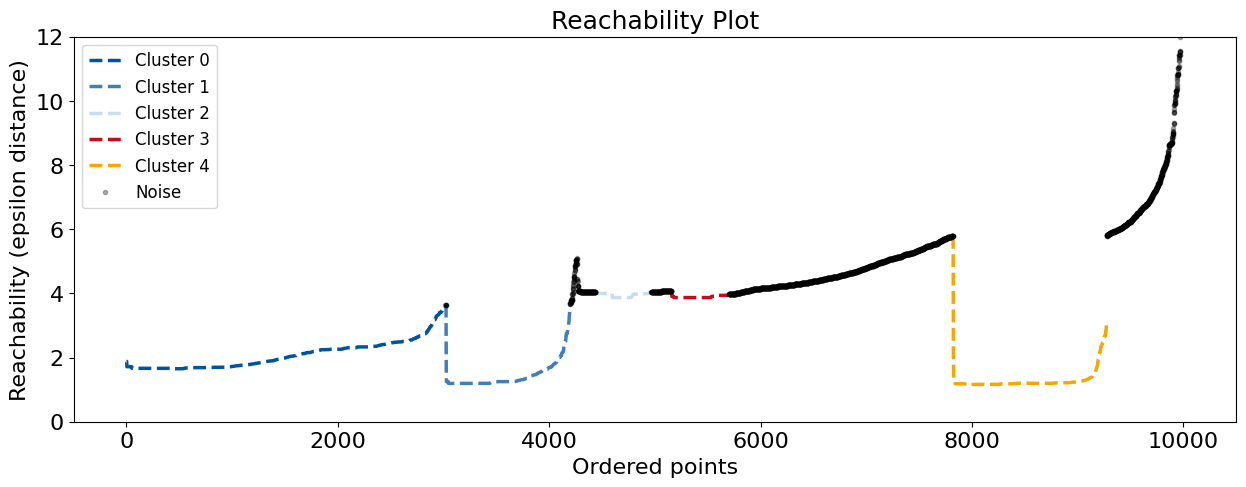

In [36]:
eps_value = 3.8 # this value represents a cutoff for a dbscan to perforem clustering
# dbscan clustering would be an alternative to the Xi clustering

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Reachability plot
num_labels = len(set(labels_xi_ord))-1
for klass in range(num_labels):
    Xk = space[labels_xi_ord == klass]
    Rk = reachability[labels_xi_ord == klass]
    ax.plot(Xk, Rk, "k--", c=color_map[klass], alpha=1, label='Cluster {}'.format(klass), linewidth=2.5)
ax.plot(space[labels_xi_ord == -1], reachability[labels_xi_ord == -1], 'k.', alpha=0.3, label='Noise')
# plot eps_value for dbscan
# ax.plot(space, np.full_like(space, eps_value, dtype=float), 'k-.', alpha=0.5, label='Eps cutoff')
ax.set_ylabel('Reachability (epsilon distance)')
ax.set_xlabel('Ordered points')
ax.set_title('Reachability Plot', fontsize=18)
ax.set_ylim(0, 12)

ax.legend(loc="upper left")

fig.savefig("ALL MODELS reachability plot.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

### Clusters can be evaluated using the XI method (from the OG paper)
https://dl.acm.org/doi/pdf/10.1145/304181.304187

[[0.         0.32941176 0.62352941]
 [0.25098039 0.49803922 0.71764706]
 [0.78039216 0.86666667 0.94901961]
 [0.8        0.02745098 0.11764706]
 [0.96470588 0.65882353 0.        ]
 [0.30196078 0.30196078 0.30196078]
 [0.62745098 0.62745098 0.62745098]] {'trpo', 'td3', 'a2c', 'acktr', 'ppo2', 'sac', 'ddpg'}


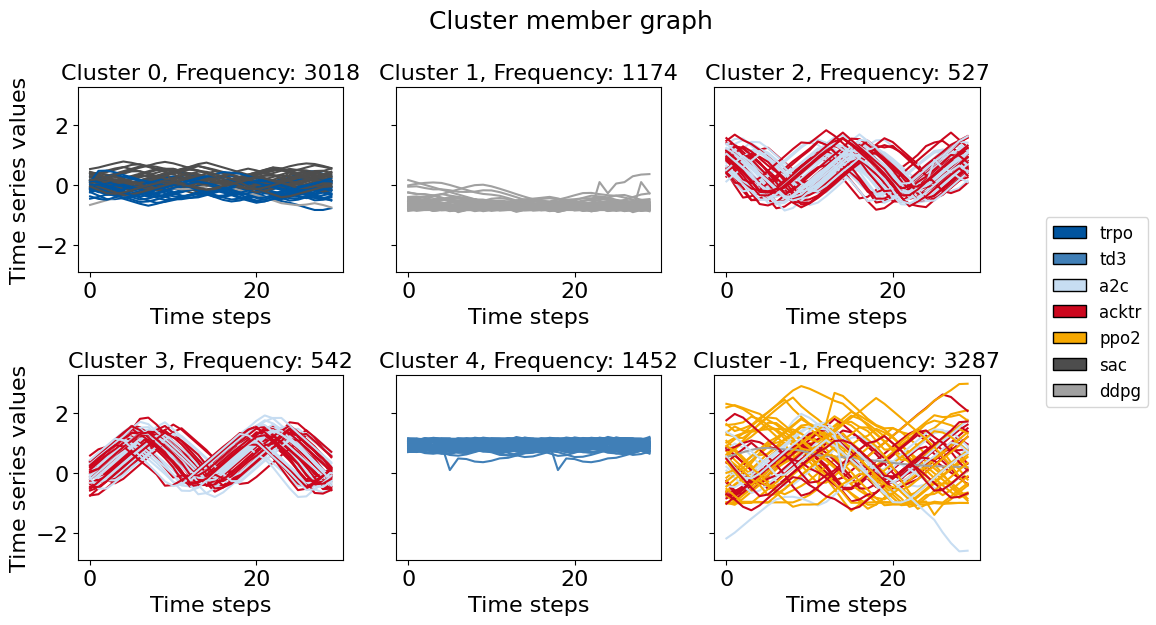

In [38]:
# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      [64, 127, 183],     # dark medium blue
                      # [142, 186, 229],    # light medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255

# map colors to different models
colors = color_map # cm.rainbow(np.linspace(0, 1, len(set(sts_df_all['model']))))
cmap = {}
for c, model_name in zip(colors, set(sts_df_all['model'])):
    cmap[model_name] = c


nrows = int(np.sqrt(len(set(labels_xi))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_xi)) else nrows + 2

nrows = 2 # HARDCODE
ncols = 3

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, 6), sharey=True)# ncols*6, nrows*4))

for i, label in enumerate(set(labels_xi)): 

    cluster_ind = np.where([labels_xi == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # the first column is the model
    points = sts_df_all.values[cluster_ind, 1:]
    # get the models to the corresponding points
    point_models = sts_df_all.values[cluster_ind, 0]

    # plot cluster
    for ii, yy in enumerate(points):
        color = cmap[point_models[ii]]
        ax.ravel()[i].plot(yy, c=color)
    
    label_freq = np.where([labels_xi==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
    ax.ravel()[i].set_xlabel("Time steps")

ax.ravel()[0].set_ylabel("Time series values")
ax.ravel()[3].set_ylabel("Time series values")

fig.text(0.5, 1.03, 'Cluster member graph', va="center", ha="center", fontsize=18)

handles = [mpatches.Patch(facecolor=c, edgecolor='#000000') for c in cmap.values()]
fig.legend(handles=handles, labels=cmap.keys(), loc="right")

fig.tight_layout()
plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend

fig.savefig("ALL MODELS cluster member graph.svg",   # alternatively use .svg
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )

print(colors, set(sts_df_all['model']))

Use this next plot to produce a legend for the models.

In [ ]:
for k, v in zip(cmap.keys(), cmap.values()):
    plt.plot(range(10), c=v, label=k)
plt.legend()    

### Alternatively cluster with DBSCAN with results from Reachability plot

In [ ]:
labels_dbscan = cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=eps_value)


# map colors to different models
colors = cm.rainbow(np.linspace(0, 1, len(set(sts_df_all['model']))))
cmap = {}
for c, model_name in zip(colors, set(sts_df_all['model'])):
    cmap[model_name] = c


nrows = int(np.sqrt(len(set(labels_dbscan))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_dbscan)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))

for i, label in enumerate(set(labels_dbscan)): 

    cluster_ind = np.where([labels_dbscan == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # the first column is the model
    points = sts_df_all.values[cluster_ind, 1:]
    # get the models to the corresponding points
    point_models = sts_df_all.values[cluster_ind, 0]

    # plot cluster
    for ii, yy in enumerate(points):
        color = cmap[point_models[ii]]
        ax.ravel()[i].plot(yy, c=color)
    
    label_freq = np.where([labels_dbscan==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
        
plt.show()

print(colors, set(sts_df_all['model']))

In [ ]:
plt.

## Using Agglomerative Clustering

https://stackoverflow.com/questions/53849107/sklearn-agglomerative-clustering-custom-affinity

In [ ]:
# Method to calculate distances between all sample pairs
from sklearn.metrics import pairwise_distances
def sim_affinity(X):
    return pairwise_distances(X, metric=mydtw)

In [ ]:
ward = AgglomerativeClustering(n_clusters=8, distance_threshold=None, affinity=sim_affinity, linkage='average')
ward.fit(X_all[:500, :])

labels_ward = ward.labels_

In [ ]:
len(set(labels_ward))

In [ ]:
# map colors to different models
colors = cm.rainbow(np.linspace(0, 1, len(set(sts_df_all['model']))))
cmap = {}
for c, model_name in zip(colors, set(sts_df_all['model'])):
    cmap[model_name] = c


nrows = int(np.sqrt(len(set(labels_ward))))
ncols = nrows + 1 if nrows**2+1==len(set(labels_ward)) else nrows + 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))

for i, label in enumerate(set(labels_ward)): 

    cluster_ind = np.where([labels_ward == label])[1]
    # plot only every 50th element if cluster has more than 100 elements
    is_selection = False
    if len(cluster_ind) > 50: 
        cluster_ind = cluster_ind[::len(cluster_ind)//50]
        is_selection = True

    # the first column is the model
    points = sts_df_all.values[cluster_ind, 1:]
    # get the models to the corresponding points
    point_models = sts_df_all.values[cluster_ind, 0]

    # plot cluster
    for ii, yy in enumerate(points):
        color = cmap[point_models[ii]]
        ax.ravel()[i].plot(yy, c=color)
    
    label_freq = np.where([labels_ward==label])[1].shape[0]
    ax.ravel()[i].set_title('Cluster {}, Frequency: {}'.format(label, label_freq))
        
plt.show()

# Others/ Outlook: PCA Visualisation

In [ ]:
hpc = PCA(n_components=2).fit_transform(X_all)
k_means = KMeans().fit(hpc)

x_min, x_max = hpc[:, 0].min(), hpc[:, 0].max()
y_min, y_max = hpc[:, 1].min(), hpc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')

plt.plot(hpc[:, 0], hpc[:, 1], 'k.', markersize=1)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### STS clustering with KMeans(metric=...) using Euclidian, DTW and soft-DTW

In [ ]:
%%time

X_train = sts_df.values[:, :]
n_clusters = 3

seed = 0
np.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:100])
# Make time series shorter
#X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure(figsize=(20, 10))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred == yi][::10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, n_clusters+1 + yi)
    for xx in X_train[y_pred == yi][::10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=False,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, 2*n_clusters+1 + yi)
    for xx in X_train[y_pred == yi][::10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()